# Обучение модели

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

## Загружаем данные

In [ ]:
# имортируем необходимые библиотеки
from google.colab import drive
import os
import subprocess


In [ ]:
# Подключитесь к Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/FEFU/Cyrillic_Test.zip"

In [ ]:
!unzip "/content/drive/My Drive/FEFU/Cyrillic_Train_Validation.zip"

In [ ]:
!unzip "/content/drive/My Drive/FEFU/Cyrillic_Train_Validation_314.zip"

In [ ]:
# !rm -rf Cyrillic_Train_Validation_314

## Создаем Tensorflow Dataset'ы

In [ ]:
# batch_size=32
batch_size=1024

image_size=(28, 28)

In [ ]:
from tensorflow.keras import layers

# Создаем слой нормализации
rescale = layers.Rescaling(1./255)

# Применяем слой к вашему набору данных
# train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))

**Набор данных для обучения**

In [ ]:
train_dataset = image_dataset_from_directory('Cyrillic_Train_Validation_314',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.2,
                                             batch_size=batch_size,
                                             color_mode="grayscale",
                                             image_size=image_size)


r_train_dataset = train_dataset.map(lambda x, y: (rescale(x), y))

Found 227750 files belonging to 33 classes.
Using 182200 files for training.


**Проверочный набор данных**

In [ ]:
validation_dataset = image_dataset_from_directory('Cyrillic_Train_Validation_314',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.2,
                                             batch_size=batch_size,
                                             color_mode="grayscale",
                                             image_size=image_size)

r_validation_dataset = validation_dataset.map(lambda x, y: (rescale(x), y))

Found 227750 files belonging to 33 classes.
Using 45550 files for validation.


Названия классов в наборах данных.

In [ ]:
class_names = train_dataset.class_names
class_names

['Ё',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я']

**Примеры изображений**

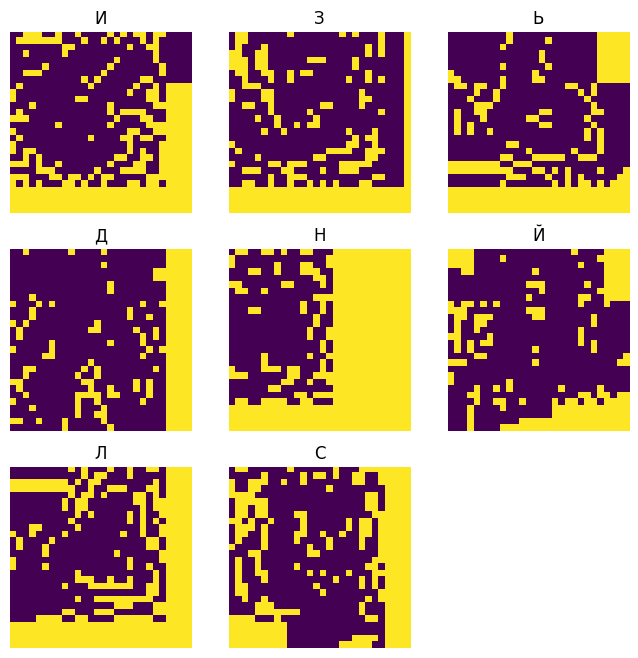

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in r_train_dataset.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [ ]:
test_dataset = image_dataset_from_directory('Cyrillic_Test',
                                             batch_size=batch_size,
                                             color_mode="grayscale",
                                             image_size=image_size)

r_test_dataset = test_dataset.map(lambda x, y: (rescale(x), y))

Found 990 files belonging to 33 classes.


In [ ]:
test_dataset.class_names

['Ё',
 'А',
 'Б',
 'В',
 'Г',
 'Д',
 'Е',
 'Ж',
 'З',
 'И',
 'Й',
 'К',
 'Л',
 'М',
 'Н',
 'О',
 'П',
 'Р',
 'С',
 'Т',
 'У',
 'Ф',
 'Х',
 'Ц',
 'Ч',
 'Ш',
 'Щ',
 'Ъ',
 'Ы',
 'Ь',
 'Э',
 'Ю',
 'Я']

## Настраиваем производительность TensorFlow DataSet'ов

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

r_train_dataset = r_train_dataset.prefetch(buffer_size=AUTOTUNE)
r_validation_dataset = r_validation_dataset.prefetch(buffer_size=AUTOTUNE)
r_test_dataset = r_test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [ ]:
# 4ms/step - loss: 0.0735 - accuracy: 0.9798 - sparse_categorical_accuracy: 0.9798
#21ms/step - loss: 0.1131 - accuracy: 0.9646 - sparse_categorical_accuracy: 0.9646


model = Sequential()
# Сверточный слой
model.add(Conv2D(16, (3, 3), padding='same',
                 input_shape=(28, 28, 1), activation='relu'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Сверточный слой
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
# Слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))


# Полносвязная часть нейронной сети для классификации
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# Выходной слой, 33 нейрон по количеству классов
model.add(Dense(33, activation='softmax'))


**Компилируем модель**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy', 'sparse_categorical_accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          51264     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

## Обучаем нейронную сеть

In [ ]:
history = model.fit(r_train_dataset,
                    validation_data=r_validation_dataset,
                    epochs=10,
                    verbose=1)

Epoch 1/10
178/178 [==============================] - 17s 89ms/step - loss: 2.2819 - accuracy: 0.3439 - sparse_categorical_accuracy: 0.3439 - val_loss: 1.1589 - val_accuracy: 0.6675 - val_sparse_categorical_accuracy: 0.6675
Epoch 2/10
178/178 [==============================] - 16s 87ms/step - loss: 0.9682 - accuracy: 0.7027 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.6592 - val_accuracy: 0.7978 - val_sparse_categorical_accuracy: 0.7978
Epoch 3/10
178/178 [==============================] - 16s 88ms/step - loss: 0.6198 - accuracy: 0.8039 - sparse_categorical_accuracy: 0.8039 - val_loss: 0.4321 - val_accuracy: 0.8659 - val_sparse_categorical_accuracy: 0.8659
Epoch 4/10
178/178 [==============================] - 16s 87ms/step - loss: 0.4665 - accuracy: 0.8513 - sparse_categorical_accuracy: 0.8513 - val_loss: 0.3292 - val_accuracy: 0.8955 - val_sparse_categorical_accuracy: 0.8955
Epoch 5/10
178/178 [==============================] - 16s 90ms/step - loss: 0.3733 - accuracy: 0.8795 - 

## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(r_test_dataset, verbose=1)

1/1 [==============================] - 0s 102ms/step - loss: 0.0846 - accuracy: 0.9768 - sparse_categorical_accuracy: 0.9768


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 97.6768


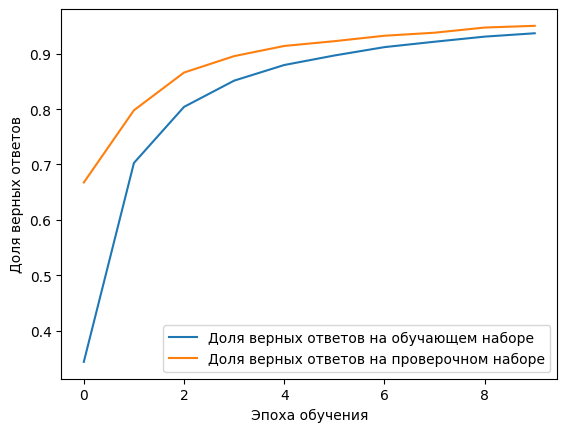

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

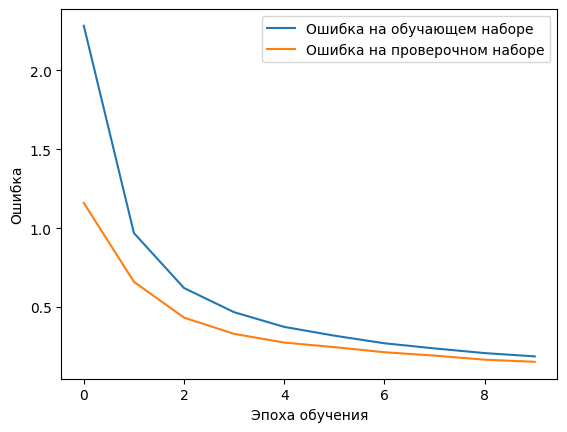

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
# # загрузить свою модель
# from keras.models import load_model

# model = load_model('100v.h5')


In [ ]:

scores = model.evaluate(r_test_dataset, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))


1/1 [==============================] - 2s 2s/step - loss: 0.0446 - accuracy: 0.9879 - sparse_categorical_accuracy: 0.9879
Доля верных ответов на тестовых данных, в процентах: 98.7879


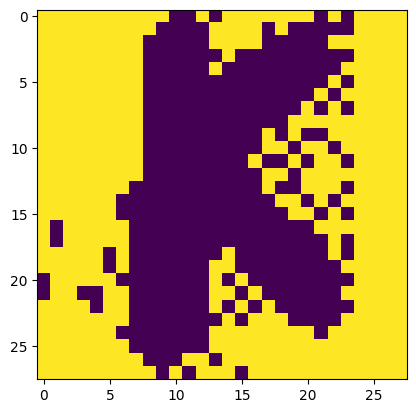

1/1 [==============================] - 0s 25ms/step
[[6.3262290e-10 9.6924887e-05 1.9439254e-07 2.7519695e-09 3.7666380e-12
  2.2558382e-07 6.0152189e-07 1.2436621e-04 6.9871486e-19 1.1115646e-14
  2.5457270e-14 9.9810398e-01 3.8452475e-15 3.6437552e-07 9.2833786e-04
  1.4381652e-13 3.9778955e-05 2.5147135e-12 5.4126040e-11 7.0449861e-04
  7.2704147e-13 2.9123765e-08 5.6951222e-07 2.6507006e-13 6.6893798e-17
  4.7741016e-11 9.2780201e-14 1.5627516e-10 1.5011747e-08 7.2662310e-12
  1.4068790e-18 6.1133107e-08 1.2949105e-12]]
11
К
1/1 [==============================] - 0s 24ms/step
Class: К, Probability: 99.81%
Class: Н, Probability: 0.09%
Class: Т, Probability: 0.07%


In [ ]:
from PIL import Image
import numpy as np

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt


image = keras.utils.load_img(
    "/content/drive/MyDrive/FEFU/4.jpg",
    target_size=(28, 28),
    color_mode="grayscale"
)
image = rescale(image)

image_array = img_to_array(image)
# Вывод изображения
plt.imshow(image_array.astype('uint8'))
plt.show()


input_arr = keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

res = model.predict(input_arr)


# res = model.predict(img_array)
print(res)
print(np.argmax(res))
print(class_names[np.argmax(res)])


import numpy as np
# Предсказание вероятностей для изображения
res = model.predict(input_arr)

# Получение индексов отсортированных по вероятности классов
sorted_indices = np.argsort(res[0])[::-1]

# Вывод трех самых вероятных результатов и их процентных вероятностей
for i in range(3):
    index = sorted_indices[i]
    print(f"Class: {class_names[index]}, Probability: {res[0][index] * 100:.2f}%")

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("100.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Сохраняем модель на локальный компьютер

In [ ]:
files.download("100.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>